In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import sys
sys.path.append('../')

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

simplefilter(action='ignore', category=FutureWarning)

In [8]:
def cal_variance(data):
    variance = xr.apply_ufunc(np.var,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return variance

In [9]:
def _compute_slope(var):
    slp = linregress(range(len(var)),var).slope
    return slp

def trend_cal(data):
    slopes = xr.apply_ufunc(_compute_slope,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

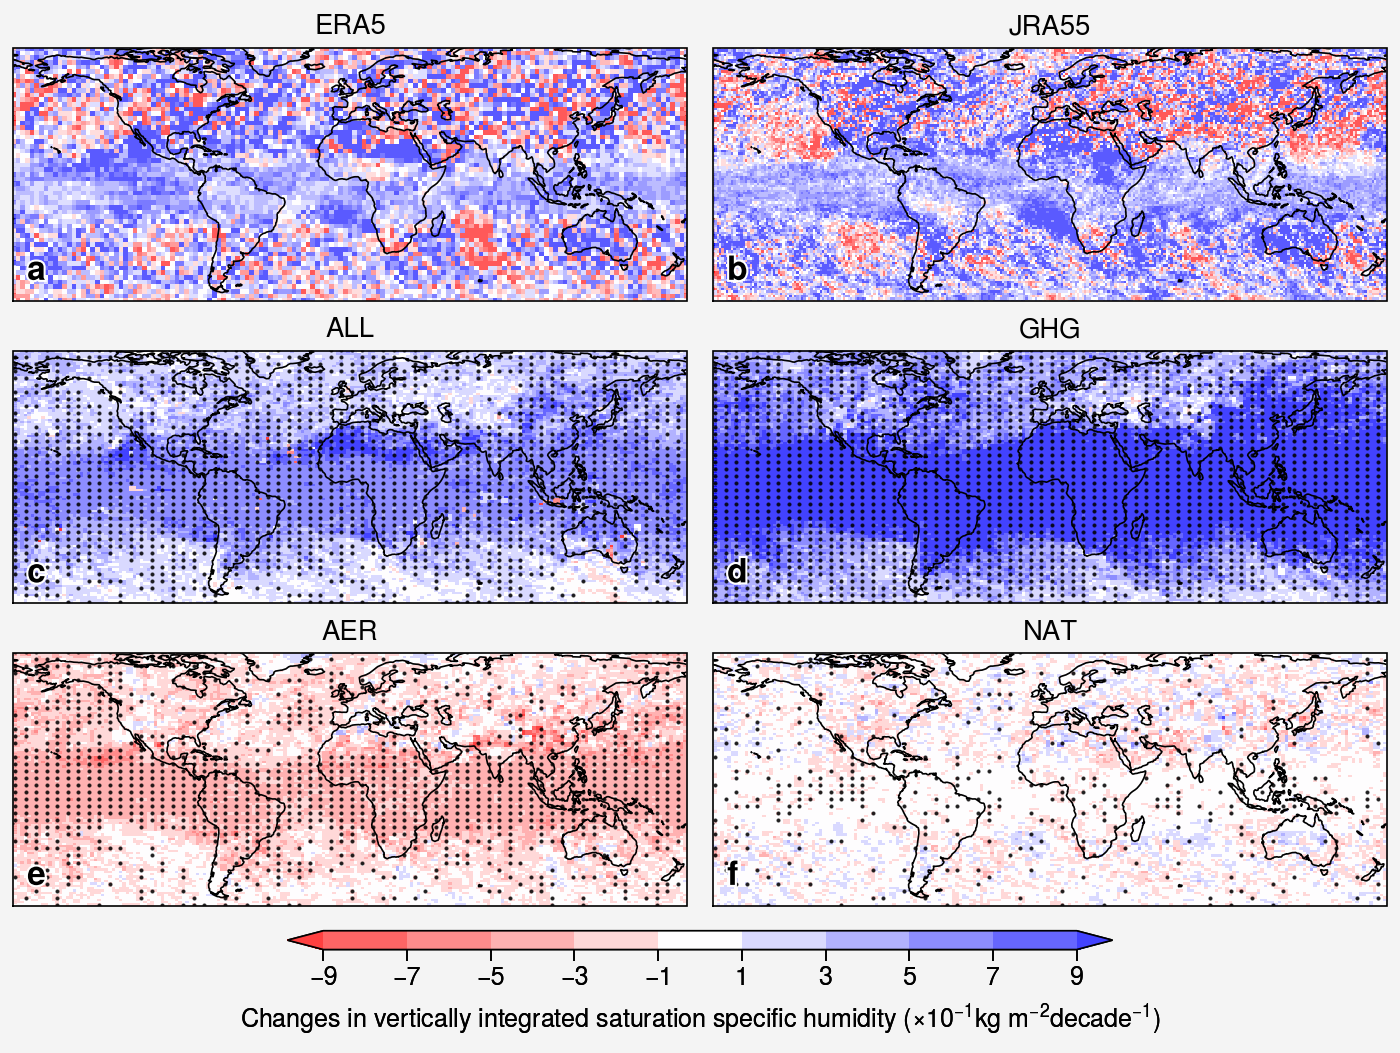

In [20]:
fig, axs = pplot.subplots(ncols=2,nrows=3,wratios=(1,1),wspace=1,hspace=2,share=False,
                        proj='pcarree',width=7)
axs.format(grid=False)
axs.format(abc=True,abcsize=12,abcloc='ll')

vmax=9
vmin=-9
levels=10

forcing_list = ['era5','jra55','historical','hist-GHG','hist-aer','hist-nat']
titles = {'era5':'ERA5','jra55':'JRA55','historical':'ALL','hist-GHG':'GHG','hist-aer':'AER','hist-nat':'NAT'}
name_list    = ['vertically_integrated_qsat','vertically_average_wap']

ax_locs  = {'era5':0,'jra55':1,'historical':2,'hist-GHG':3,'hist-aer':4,'hist-nat':5}

n = name_list[0]
for f in forcing_list:
    forcing  = f
    if forcing == 'era5' or forcing == 'jra55':
        src_id = forcing
        run = 'reanalysis'
        file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        data = xr.open_dataarray(file)
        data = trend_cal(data) * 10 * 10
        if forcing == 'era5':
            data = data.rename({'longitude':'lon','latitude':'lat'})
        lon = data['lon']
        lats1d = data['lat']
        ax_loc = ax_locs[f]
        p = axs[ax_loc].pcolormesh(lon,lats1d,data,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.65,
                            extend = 'both',cmap=cmaps.MPL_bwr_r) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[ax_loc].set_title(titles[f])

    else:
        ensemble = ensembles[f]
        ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + n + '_day_' + i + '*.nc')]
        ens_num  = len(ensemble)

        mmm_data  = 0
        acc_sign_up_num = 0
        acc_sign_down_num = 0
        
        for i in ensemble:
            src_id = i.split('_')[0]
            run    = i.split('_')[2]
            pi_time = i.split('_')[3]

            file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
            data = xr.open_dataarray(file)
            data = trend_cal(data) * 10 * 10
            data = Regridder(data)
            data = data.interpolate_na(dim="lon", method="linear",fill_value="extrapolate")
            mmm_data   = mmm_data + data

            acc_sign_up_num  = acc_sign_up_num + (data > 0)*1
            acc_sign_down_num  = acc_sign_down_num + (data < 0)*1

        mmm_data  = mmm_data / ens_num
        mmm_sig  = ((mmm_data>0)*(acc_sign_up_num>=ens_num*2/3)) + ((mmm_data<0)*(acc_sign_down_num>=ens_num*2/3))

        lons1d = mmm_data['lon']
        lats1d = mmm_data['lat']
        data1  = mmm_data
        ax_loc = ax_locs[f]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'both',cmap=cmaps.MPL_bwr_r) #CBR_wet #WhiteYellowOrangeRed #MPL_YlOrRd
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)
        axs[ax_loc].set_title(titles[f])

        data2  = mmm_sig
        X,Y = np.meshgrid(lons1d[::3],lats1d[::3]) 
        sig = data2[::3,::3]
        X = X[sig]
        Y = Y[sig]
        axs[ax_loc].scatter(X,Y,s=0.8,c='black',alpha=0.75)

fig.colorbar(p,loc='b',width='0.75em',cols=(1,2),title='Changes in vertically integrated saturation specific humidity (×${10^{-1}}$kg ${m^{-2}}$${decade^{-1}}$)',length=0.6)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS21_trends_of_vertically_integrated_qsat.pdf')